<a href="https://colab.research.google.com/github/viti1igo/SiameseNetwork/blob/main/siamese_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torchvision.utils
from torchvision import datasets

import torch
import torch.utils.data as utils
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
from torch.utils.data import random_split

import random
import numpy as np
from PIL import Image

In [ ]:
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: cuda


#Data Preprocessing

In [ ]:
class OmniglotTripletDataset(Dataset):
    def __init__(self, dataset, transform=None):
        if len(dataset) == 0:
            raise ValueError("The dataset is empty. Please provide a valid dataset.")

        self.dataset = dataset
        self.transform = transform
        self.character_classes = self._build_character_classes()

    def _build_character_classes(self):
        character_classes = {}
        for idx, (img, label) in enumerate(self.dataset):
            if label not in character_classes:
                character_classes[label] = []
            character_classes[label].append(idx)
        return character_classes

    def _sample_negative_class(self, positive_class):
        if len(self.character_classes) <= 1:
            raise ValueError("The dataset contains less than 2 classes. Can't sample a negative class.")

        negative_class = random.choice(list(self.character_classes.keys()))
        while negative_class == positive_class:
            negative_class = random.choice(list(self.character_classes.keys()))

        return negative_class

    def __getitem__(self, idx):
        # Anchor image
        anchor_img, anchor_label = self.dataset[idx]

        # Sample positive image
        positive_idx = random.choice(self.character_classes[anchor_label])
        positive_img, _ = self.dataset[positive_idx]

        # Sample negative image
        negative_label = self._sample_negative_class(anchor_label)
        negative_idx = random.choice(self.character_classes[negative_label])
        negative_img, _ = self.dataset[negative_idx]

        # Apply transformations only if the image is not already a tensor
        if self.transform:
            if isinstance(anchor_img, Image.Image):
                anchor_img = self.transform(anchor_img)
            if isinstance(positive_img, Image.Image):
                positive_img = self.transform(positive_img)
            if isinstance(negative_img, Image.Image):
                negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img

    def __len__(self):
        return len(self.dataset)

In [ ]:
#Image resizing
transform_func = transforms.Compose([transforms.Resize((105, 105)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

#Load Omniplot dataset
omniglot_dataset = datasets.Omniglot(
    root='./data',
    download=True,
    background=True,
    transform=transform_func
)
omni_triplet_dataset = OmniglotTripletDataset(omniglot_dataset, transform=transform_func)

total_size = len(omni_triplet_dataset)
train_size = int(0.9 * total_size)
test_size = total_size - train_size

# Split the dataset
train_dataset, test_dataset = random_split(omni_triplet_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the sizes for confirmation
print(f"Training set size: {len(train_dataset)}")
print(f"Testing set size: {len(test_dataset)}")



100%|██████████| 9.46M/9.46M [00:00<00:00, 87.6MB/s]


Extracting ./data/omniglot-py/images_background.zip to ./data/omniglot-py
Training set size: 17352
Testing set size: 1928


#Build a Siamese Network

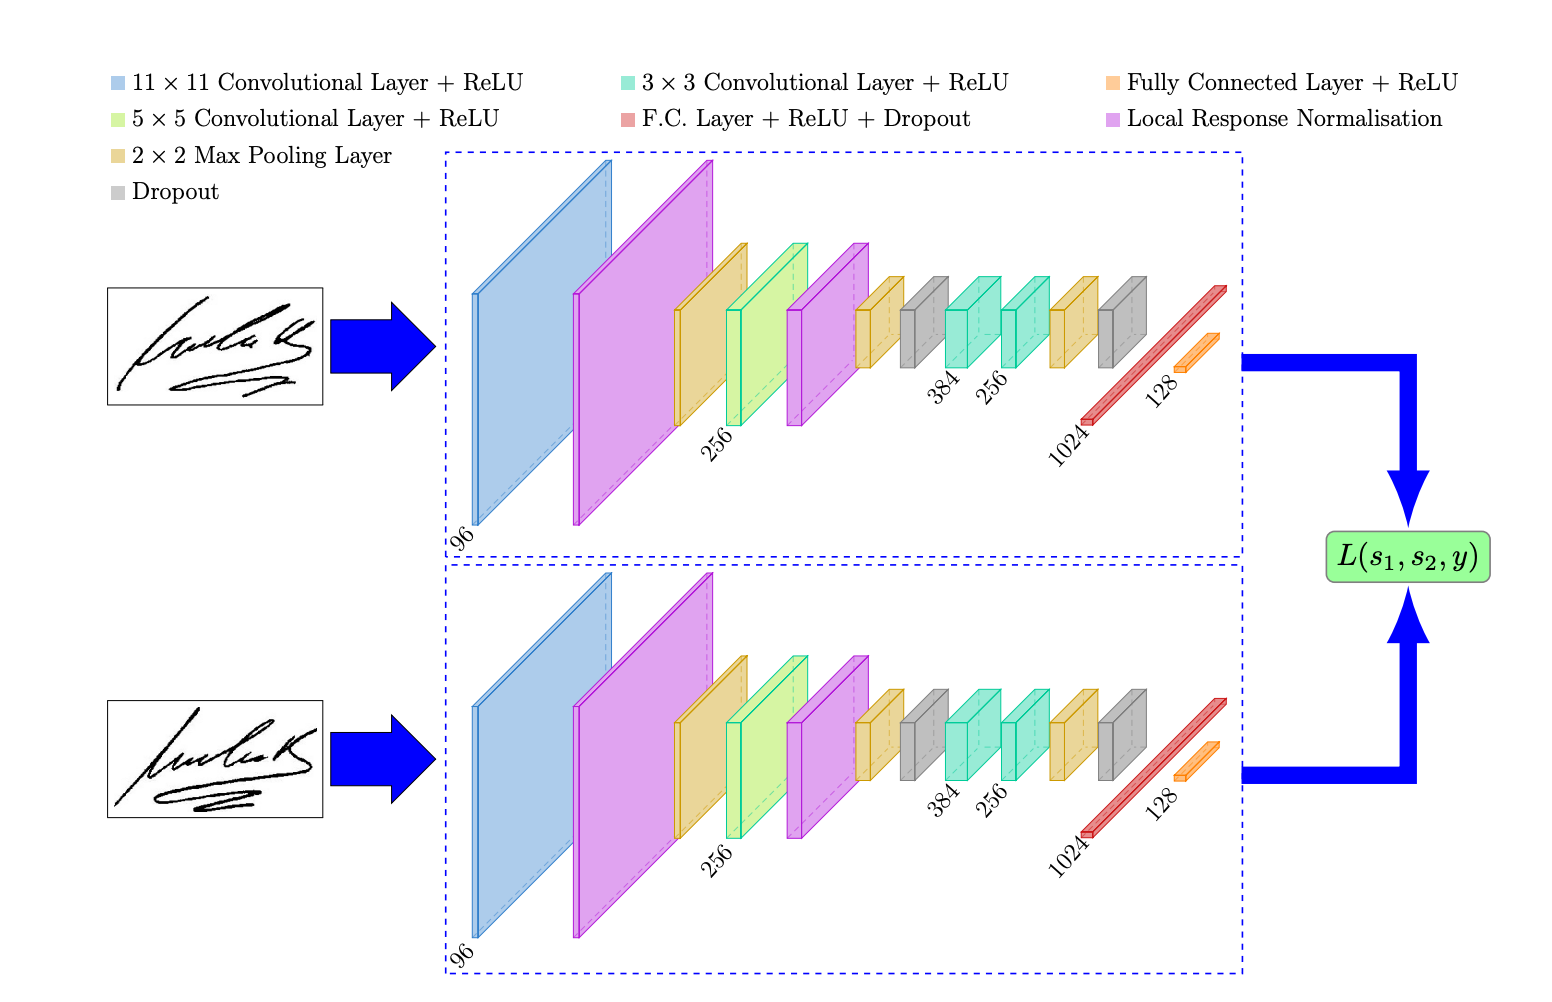

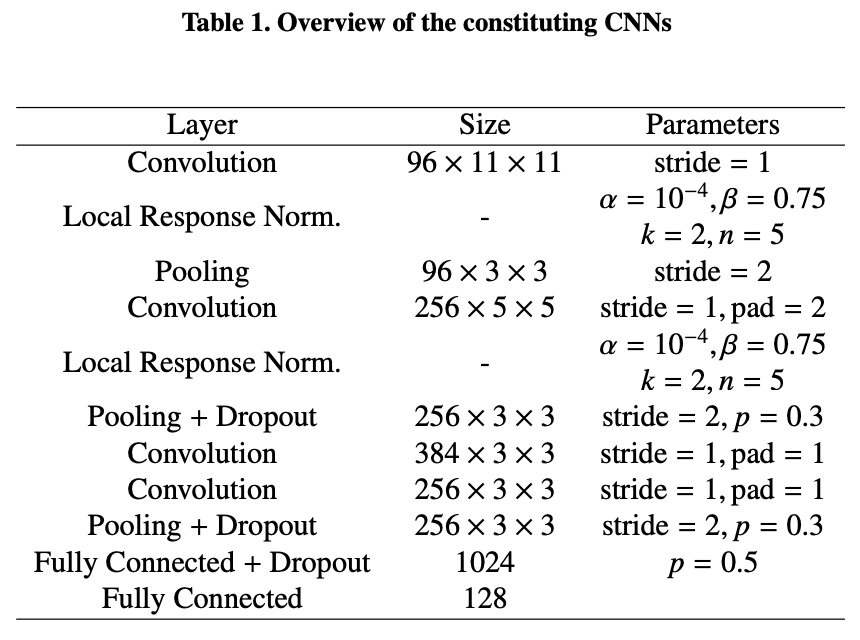

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11, stride=1),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout2d(p=0.3),
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        #Fully Connected Layers
        self.fc=nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True)
        )
    #Forward per image
    def forward_once(self, x):
      output=self.cnn(x)
      output=output.view(output.size()[0], -1)
      output=self.fc(output)
      return output
    #Forward per pair
    def forward(self, input1, input2, input3):
      output1=self.forward_once(input1)
      output2=self.forward_once(input2)
      output3=self.forward_once(input3)
      return output1, output2, output3

We will use the TripletMarginLoss which is a subset of TripletLoss.

#Deploy Model

In [ ]:
model = SiameseNetwork().to(device)
criterion = nn.TripletMarginLoss(margin=1.0, p=2)
optimizer = optim.SGD(model.parameters(), lr=0.01) #Adam/SGD

#Training Loop

In [ ]:
num_epochs =  20

In [ ]:
def train(model, train_loader, criterion, optimizer, num_epochs, device):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_batches = len(train_loader)

        for i, (anchor, positive, negative) in enumerate(train_loader):
            # Move data to the device (GPU/CPU)
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            anchor_output, positive_output, negative_output = model(anchor, positive, negative)

            # Compute the loss (Triplet Margin Loss)
            loss = criterion(anchor_output, positive_output, negative_output)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Accumulate the loss
            running_loss += loss.item()

        # Compute average loss for the epoch
        avg_loss = running_loss / total_batches
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}")

    print("Training completed.")

In [ ]:
train(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

Epoch 1/20 - Loss: 0.6155
Epoch 2/20 - Loss: 0.3057
Epoch 3/20 - Loss: 0.2612
Epoch 4/20 - Loss: 0.2395
Epoch 5/20 - Loss: 0.2136
Epoch 6/20 - Loss: 0.2033
Epoch 7/20 - Loss: 0.2002
Epoch 8/20 - Loss: 0.1851
Epoch 9/20 - Loss: 0.1838
Epoch 10/20 - Loss: 0.1733
Epoch 11/20 - Loss: 0.1697
Epoch 12/20 - Loss: 0.1610
Epoch 13/20 - Loss: 0.1631
Epoch 14/20 - Loss: 0.1493
Epoch 15/20 - Loss: 0.1455
Epoch 16/20 - Loss: 0.1437
Epoch 17/20 - Loss: 0.1324
Epoch 18/20 - Loss: 0.1344
Epoch 19/20 - Loss: 0.1215
Epoch 20/20 - Loss: 0.1192
Training completed.


#Evaluate the model

In [ ]:
def evaluate(model, train_loader, test_loader, device):
    model.eval()  # Set the model to evaluation mode

    def run_evaluation(data_loader):
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():  # Disable gradient calculation during evaluation
            for anchor, positive, negative in data_loader:
                # Move input data to the device (GPU or CPU)
                anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

                # Forward pass through the model
                anchor_output, positive_output, negative_output = model(anchor, positive, negative)

                # Compute the triplet margin loss
                loss = F.triplet_margin_loss(anchor_output, positive_output, negative_output, margin=1.0, p=2)
                total_loss += loss.item()

                # Measure if the anchor is closer to the positive than to the negative
                ap_dist = F.pairwise_distance(anchor_output, positive_output)
                an_dist = F.pairwise_distance(anchor_output, negative_output)

                # Count the number of correct predictions
                correct += (ap_dist < an_dist).sum().item()
                total += anchor.size(0)

        # Compute average loss and accuracy
        avg_loss = total_loss / len(data_loader)
        accuracy = correct / total if total > 0 else 0
        return avg_loss, accuracy

    # Evaluate on both training and testing sets
    train_loss, train_accuracy = run_evaluation(train_loader)
    test_loss, test_accuracy = run_evaluation(test_loader)

    # Print the results
    print(f"Training Set - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
    print(f"Testing Set - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")

In [ ]:
results = evaluate(model, train_loader, test_loader, device)
print(results)

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1538: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Training Set - Loss: 0.0659, Accuracy: 0.9754
Testing Set - Loss: 0.0608, Accuracy: 0.9803
None
